In [1]:
import numpy as np
import dill
import importlib
import os
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import numba as nb
import time

import read_data_functions as rdf
import plot_functions as pf
import Optimal_Stopping_Object as oso
import Subject_Object_v2
%load_ext autoreload
%autoreload 2

# Select Exp1 or Exp2


In [2]:
experiment = "Exp1"

# Initial Thangs


In [3]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
PATH = os.getcwd()
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH + "\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH + "\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == "Exp2":
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Payoff Condition"
if experiment == "Exp1":
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = "1100 (50)"
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = "1200 (150)"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Mean [SD] Agent Decision Time (ms)"
num_subjects

20

# Pickle Data


In [4]:
if "subject_objects" not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    subject_objects2 = copy.deepcopy(subject_objects)
    # group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2,
    #                                     task_leave_time_metric_name = 'player_pos_task_leave_time', task_movement_time_metric_name = 'player_pos_task_movement_time',
    #                                     reaction_time_metric_name = 'player_pos_reaction_time', reaction_movement_time_metric_name = 'player_pos_reaction_movement_time')
    # group.analyze_data()
    group = Subject_Object_v2.Group(
        subject_objects2,
        select_trials="All Trials",
        num_stds_for_reaction_time=2,
        task_leave_time_metric_name="player_velocity_task_leave_time_thresh",
        task_movement_time_metric_name="player_velocity_task_movement_time_thresh",
        reaction_time_metric_name="player_velocity_reaction_time_thresh",
        reaction_movement_time_metric_name="player_velocity_reaction_movement_time_thresh",
    )
    group.analyze_data()

Sub1
Sub2
Sub3
Sub4
Sub5
Sub6
Sub7
Sub8
Sub9
Sub10
Sub11
Sub12
Sub13
Sub14
Sub15
Sub16
Sub17
Sub18
Sub19
Sub20


D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Subject_Object_v2.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.mu_s = (self.phat_correct*self.mhat_correct - self.phat_error*self.mhat_error)/(self.phat_correct - self.phat_error)
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Subject_Object_v2.py:568: RuntimeWarning: divide by zero encountered in true_divide
  self.mu_s_alternate = (self.phat_correct*self.mhat_correct_alternate - self.phat_error*self.mhat_error_alternate)/(self.phat_correct - self.phat_error)


In [5]:
# from pyheat import PyHeat
# # os.chdir(os.getcwd())
# ph = PyHeat('D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Optimal_Stopping_Object.py')
# ph.create_heatmap()

# Create Model


Set inputs for model

In [6]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.reaction_time, axis=1)) - 15
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.react_reaction_time_only_react, axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.player_task_movement_time, axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.player_task_movement_time, axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.coincidence_reach_time, axis=1))] * num_blocks)
perc_wins_both_reach = np.nanmean(group.perc_gamble_wins_when_both_decide, axis=0)
gamble_sd            = np.nanmedian(np.nanstd(group.player_gamble_task_leave_time, axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.agent_task_leave_time, axis=2), axis=0)
agent_means          = np.nanmean(np.nanmean(group.agent_task_leave_time, axis=2), axis=0)



Run model without switch cost

In [7]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_no_switch_cost = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time={"true": rt, "exp": rt},
    movement_time={"true": mt, "exp": mt},
    reaction_sd={"true": rt_sd, "exp": rt_sd},
    movement_sd={"true": mt_sd, "exp": mt_sd},
    timing_sd={"true": time_sd, "exp": time_sd},
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_delay_known=True,
    gamble_sd_known=True,
    gamble_switch_sd={"true": 10, "exp": 10},
    gamble_switch_delay={'true': 0, 'exp': 0},
    electromechanical_delay={"true": 50, "exp": 50},
    electromechanical_sd={"true": 10, "exp": 10},
    expected=True,
    switch_cost_exists = False,
)


Run model with switch cost

In [8]:
start = time.time()
model_expected = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time={"true": rt, "exp": rt},
    movement_time={"true": mt, "exp": mt},
    reaction_sd={"true": rt_sd, "exp": rt_sd},
    movement_sd={"true": mt_sd, "exp": mt_sd},
    timing_sd={"true": time_sd, "exp": time_sd},
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_sd={"true": 40, "exp": 0},
    gamble_switch_delay={'true': 75, 'exp': 0},
    electromechanical_delay={"true": 50, "exp": 50},
    electromechanical_sd={"true": 10, "exp": 10},
    gamble_delay_known=True,
    gamble_sd_known=True,
    expected=True,
    switch_cost_exists = True,
)

model_true = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time={"true": rt, "exp": rt},
    movement_time={"true": mt, "exp": mt},
    reaction_sd={"true": rt_sd, "exp": rt_sd},
    movement_sd={"true": mt_sd, "exp": mt_sd},
    timing_sd={"true": time_sd, "exp": time_sd},
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_sd={"true": 40, "exp": 0},
    gamble_switch_delay={'true': 75, 'exp': 0},
    electromechanical_delay={"true": 50, "exp": 50},
    electromechanical_sd ={"true": 10, "exp": 10},
    expected=False,
    gamble_delay_known=True,
    gamble_sd_known=True,
    switch_cost_exists = True,
)
end = time.time()
print(end - start)

0.17307162284851074


# Tune Model


In [9]:
np.set_printoptions(formatter={"float": lambda x: "{0:0.9f}".format(x)})
o = model_true
print(f'Reaction Time Mean (SD):     {o.inputs.reaction_time["exp"]:0.3f} ({o.inputs.reaction_sd["exp"]:0.3f})')
print(f'Movement Time Mean (SD):     {o.inputs.movement_time["exp"]:0.3f} ({o.inputs.movement_sd["exp"]:0.3f})')
print(f'Timing Uncertainty:          {o.inputs.timing_sd["exp"]}')
print(f'True Gamble Delay:           {o.inputs.gamble_delay["true"]}')
print(f'Expected Gamble Delay:       {o.inputs.gamble_delay["exp"]}')
print(f'True Gamble Uncertainty:     {o.inputs.gamble_sd["true"]}')
print(f'Expected Gamble Uncertainty: {o.inputs.gamble_sd["exp"]}')

Reaction Time Mean (SD):     251.250 (37.695)
Movement Time Mean (SD):     157.250 (26.543)
Timing Uncertainty:          [76.613683280 76.613683280 76.613683280 76.613683280 76.613683280
 76.613683280]
True Gamble Delay:           125
Expected Gamble Delay:       50
True Gamble Uncertainty:     [126.613683280 126.613683280 126.613683280 126.613683280 126.613683280
 126.613683280]
Expected Gamble Uncertainty: [96.613683280 96.613683280 96.613683280 96.613683280 96.613683280
 96.613683280]


In [11]:
model_true.fit_model(
    model_true.player_behavior.wtd_leave_time,
    np.nanmedian(np.nanmedian(group.player_task_leave_time, axis=2), axis=0),
)
model_expected.fit_model(
    model_expected.player_behavior.wtd_leave_time,
    np.nanmedian(np.nanmedian(group.player_task_leave_time, axis=2), axis=0),
)

# NOTE


## All Options Table


| Include? | Decision Times | Arrays | Outcome                                                                               |
| :------: | :------------: | :----: | :------------------------------------------------------------------------------------ |
|    Y     |  True Optimal  |  True  | True Optimal Metrics --> Ground Truth Optimal                                         |
|    N     |  True Optimal  |  Exp   | Optimizing for something that actually doesn't exist                                  |
|    Y     |    True Fit    |  True  | True player metrics --> Ground Truth Player                                           |
|    N     |    True Fit    |  Exp   | If this fit is best, the removed input actually doesn't exist                         |
|    Y     |  Exp Optimal   |  True  | True sub-optimal metrics, not accounting for the input                                |
|    N     |  Exp Optimal   |  Exp   | Expected optimal metrics if input doesn't exist                                       |
|    N     |    Exp Fit     |  True  | Doesn't make sense to use                                                             |
|    Y     |    Exp Fit     |  Exp   | What players were expecting to achieve, if they truly weren't acounting for the input |


## Only Included Table


| Include? | Model | Arrays | Decision Times | Outcome                                                                                   |                       Example Call                       |    Variable Name    |
| :------: | :---: | :----: | :------------: | :---------------------------------------------------------------------------------------- | :------------------------------------------------------: | :-----------------: |
|    Y     | True  |  True  |    Optimal     | True optimal metrics --> Ground Truth Optimal                                             | get_true_metric(true_metric_array,metric_type='optimal') | true_optimal_metric |
|    Y     | True  |  True  |      Fit       | True player metrics --> Ground Truth Player                                               |   get_true_metric(true_metric_array,metric_type='fit')   | true_player_metric  |
|    Y     |  Exp  |  True  |    Optimal     | True sub-optimal metrics, not accounting for the input                                    | get_exp_metric(true_metric_array,metric_type='optimal')  | exp_optimal_metric  |
|    Y     |  Exp  |  Exp   |      Fit       | What players were expecting to achieve,<br> if they truly weren't acounting for the input |    get_exp_metric(exp_metric_array,metric_type='fit')    |  exp_player_metric  |


So the function call is associated with the object

- Model = function call
- Arrays = first input to function call
- Decision times = second input to function call, kwarg = metric_type


## Shorten the function names


In [13]:
get_true_metric = model_true.results.get_metric
get_exp_metric = model_expected.results.get_metric
#! EXAMPLE
# * Always use the true values to get the metric (function call)
# * But metric_type 'optimal' or 'fit' determines if I use optimal decision index or fit decision index
# * If
get_true_metric(model_true.score_metrics.prob_incorrect, metric_type="fit")

array([0.092105375, 0.109024622, 0.208854235, 0.213822989, 0.408551206,
       0.297030626])

# Plots


In [14]:
save = False

In [15]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

Predicted Decision Time


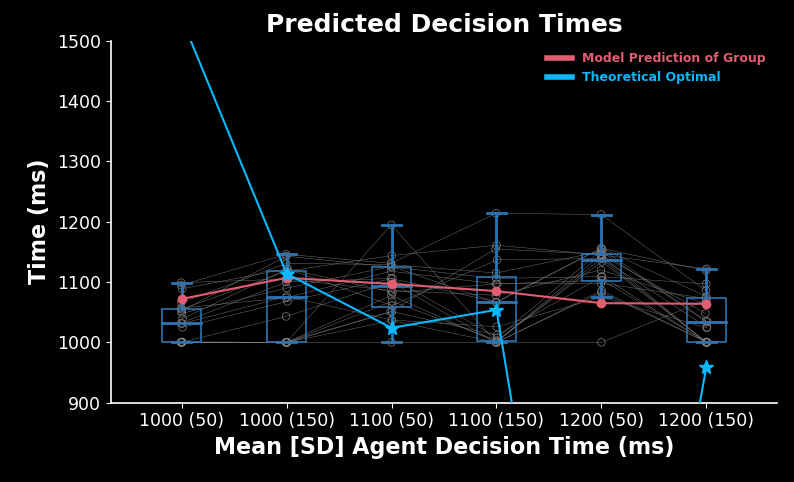

In [16]:
group.predict_stopping_times(model_true.inputs.gamble_delay["true"])
metric = group.combine_all_subjects("player_stopping_times")
true_player_metric = model_true.results.fit_decision_time
exp_player_metric = model_expected.results.fit_decision_time
true_optimal_metric = model_true.results.optimal_decision_time
exp_optimal_metric = model_expected.results.optimal_decision_time
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    true_player=true_player_metric,
    expected_player=None,
    true_optimal=true_optimal_metric,
    expected_optimal=None,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Predicted Decision Times")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

LEave Target Time


In [17]:
importlib.reload(pf)

<module 'plot_functions' from 'd:\\onedrive - university of delaware - o365\\desktop\\matchpennies-agent-expirement\\src\\plot_functions.py'>

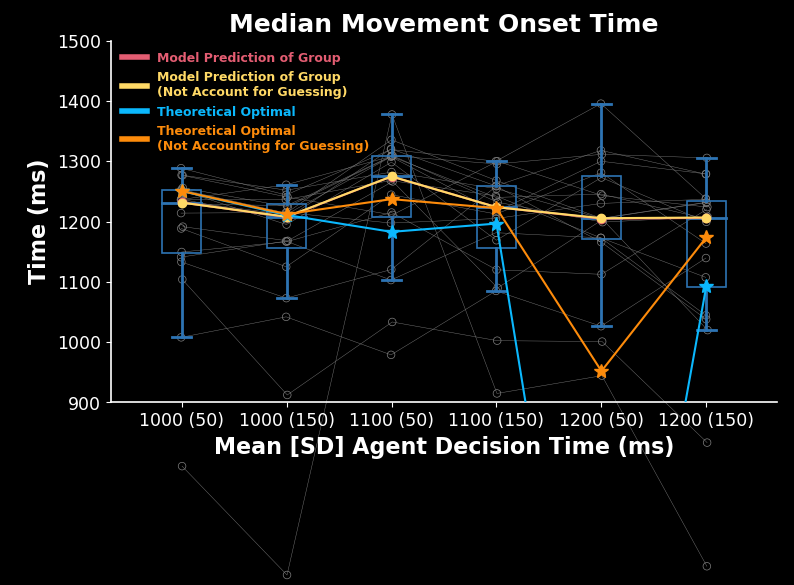

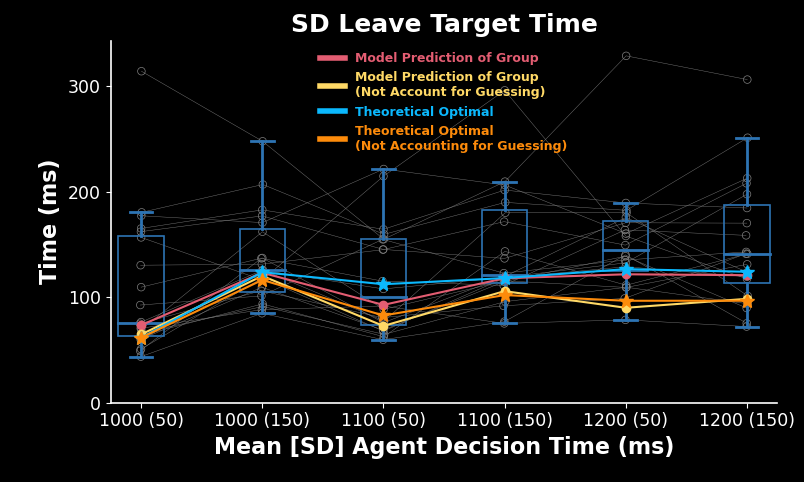

In [18]:
metric = np.nanmedian(group.player_task_leave_time, axis=2)
true_optimal_metric = get_true_metric(model_true.player_behavior.wtd_leave_time, metric_type="optimal")
true_player_metric = get_true_metric(model_true.player_behavior.wtd_leave_time, metric_type="fit")
exp_optimal_metric = get_exp_metric(model_true.player_behavior.wtd_leave_time, metric_type="optimal")
exp_player_metric = get_exp_metric(model_expected.player_behavior.wtd_leave_time, metric_type="fit")
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Median Movement Onset Time")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

metric = np.nanstd(group.player_task_leave_time, axis=2)
true_optimal_metric = get_true_metric(model_true.player_behavior.wtd_leave_time_sd, metric_type="optimal")
true_player_metric  = get_true_metric(model_true.player_behavior.wtd_leave_time_sd, metric_type="fit")
exp_optimal_metric  = get_exp_metric(model_expected.player_behavior.wtd_leave_time_sd, metric_type="optimal")  # This one uses model_expected,
exp_player_metric   = get_exp_metric(model_expected.player_behavior.wtd_leave_time_sd, metric_type="fit")
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("SD Leave Target Time")
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_expected.player_behavior.gamble_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

Wins


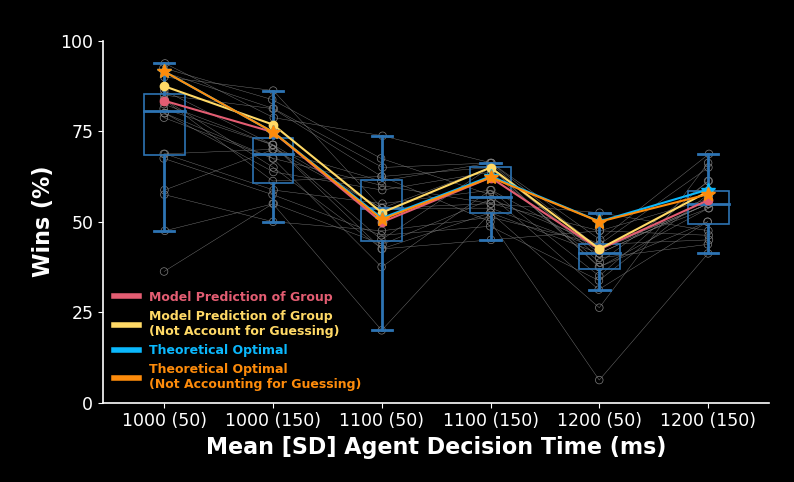

In [19]:
metric = group.player_perc_wins
true_player_metric = get_true_metric(model_true.score_metrics.prob_win, metric_type="fit") * 100
exp_player_metric = get_exp_metric(model_expected.score_metrics.prob_win, metric_type="fit") * 100
true_optimal_metric = get_true_metric(model_true.score_metrics.prob_win, metric_type="optimal") * 100
exp_optimal_metric = get_exp_metric(model_true.score_metrics.prob_win, metric_type="optimal") * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Wins (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Points


In [20]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_true.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_expected.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_true.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_true.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


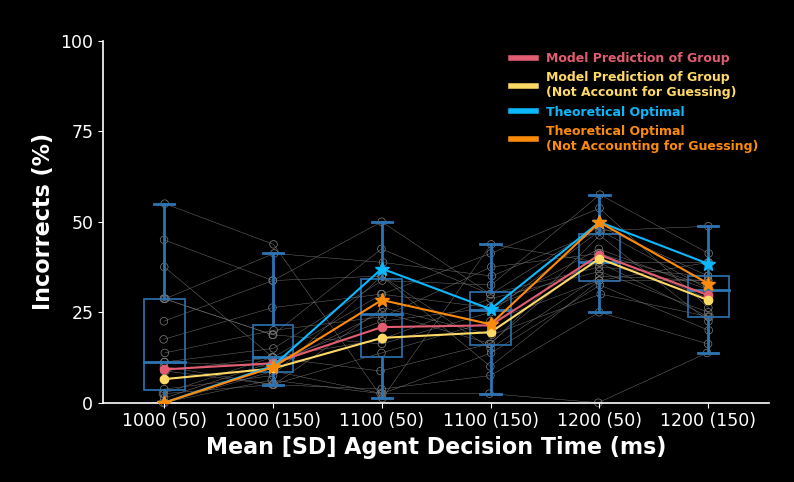

In [21]:
metric = group.player_perc_incorrects
true_player_metric = get_true_metric(model_true.score_metrics.prob_incorrect, metric_type="fit") * 100
exp_player_metric = get_exp_metric(model_expected.score_metrics.prob_incorrect, metric_type="fit") * 100
true_optimal_metric = get_true_metric(model_true.score_metrics.prob_incorrect, metric_type="optimal") * 100
exp_optimal_metric = get_exp_metric(model_true.score_metrics.prob_incorrect, metric_type="optimal") * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Incorrects (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


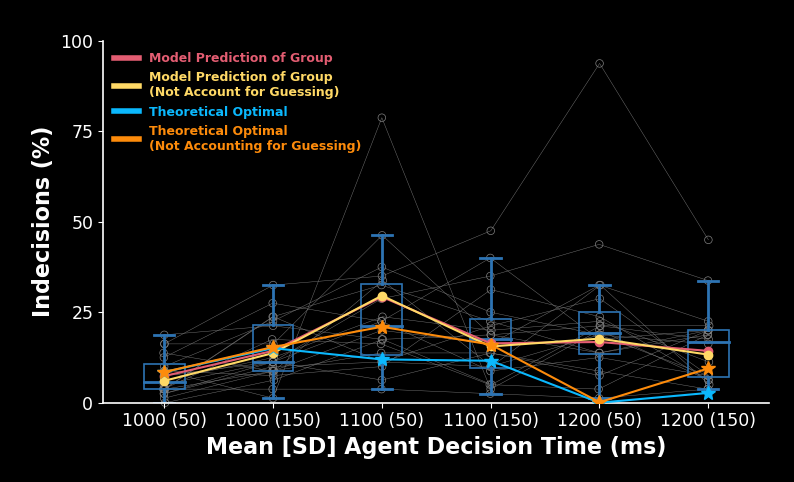

In [22]:
metric = group.player_perc_indecisions
true_player_metric = get_true_metric(model_true.score_metrics.prob_indecision, metric_type="fit") * 100
exp_player_metric = get_exp_metric(model_expected.score_metrics.prob_indecision, metric_type="fit") * 100
true_optimal_metric = get_true_metric(model_true.score_metrics.prob_indecision, metric_type="optimal") * 100
exp_optimal_metric = get_exp_metric(model_true.score_metrics.prob_indecision, metric_type="optimal") * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Indecisions (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins, Incorrects, Indecisions on One plot


Correct Initial Decisions


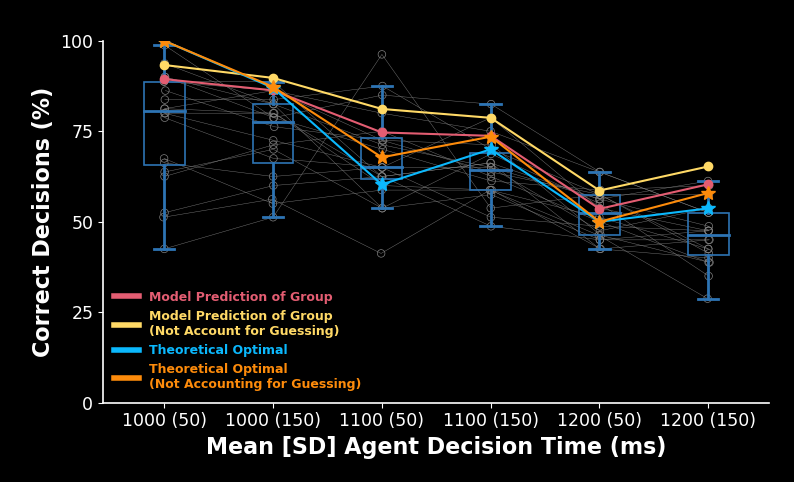

In [24]:
metric              = group.phat_correct * 100
true_player_metric  = get_true_metric(model_true.score_metrics.correct_decisions, metric_type="fit") * 100
exp_player_metric   = get_exp_metric(model_expected.score_metrics.correct_decisions, metric_type="fit") * 100
true_optimal_metric = get_true_metric(model_true.score_metrics.correct_decisions, metric_type="optimal") * 100
exp_optimal_metric  = get_exp_metric(model_true.score_metrics.correct_decisions, metric_type="optimal") * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    true_player=true_player_metric,
    expected_player=exp_player_metric,
    true_optimal=true_optimal_metric,
    expected_optimal=exp_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Correct Decisions (%)")
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions


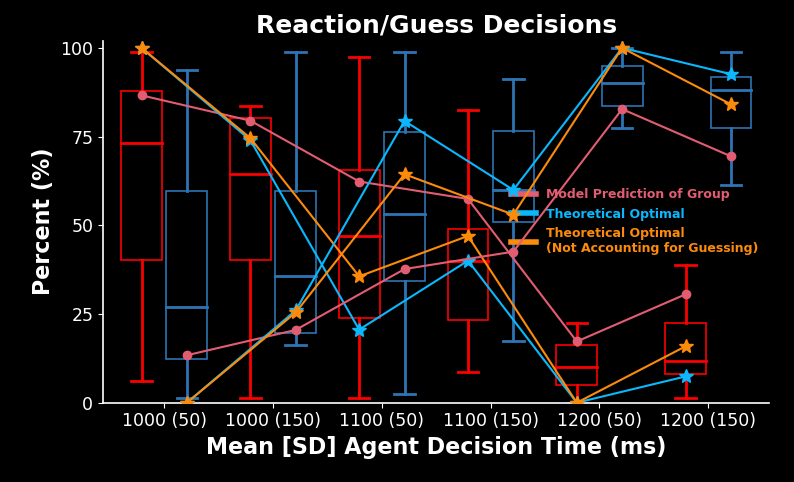

In [25]:
exp_player_metric1 = get_exp_metric(model_expected.player_behavior.prob_selecting_reaction, metric_type="fit") * 100
exp_player_metric2 = get_exp_metric(model_expected.player_behavior.prob_selecting_gamble, metric_type="fit") * 100
true_player_metric1 = get_exp_metric(model_true.player_behavior.prob_selecting_reaction, metric_type="fit") * 100
true_player_metric2 = get_exp_metric(model_true.player_behavior.prob_selecting_gamble, metric_type="fit") * 100

exp_optimal_metric1 = get_exp_metric(model_true.player_behavior.prob_selecting_reaction,metric_type='optimal') * 100
exp_optimal_metric2 = get_exp_metric(model_true.player_behavior.prob_selecting_gamble,metric_type='optimal') * 100
true_optimal_metric1 = get_true_metric(model_true.player_behavior.prob_selecting_reaction,metric_type='optimal') * 100
true_optimal_metric2 = get_true_metric(model_true.player_behavior.prob_selecting_gamble,metric_type='optimal') * 100

data_metric1 = group.combine_all_subjects("perc_reaction_decisions")
data_metric2 = group.combine_all_subjects("perc_gamble_decisions")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=None,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=None,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


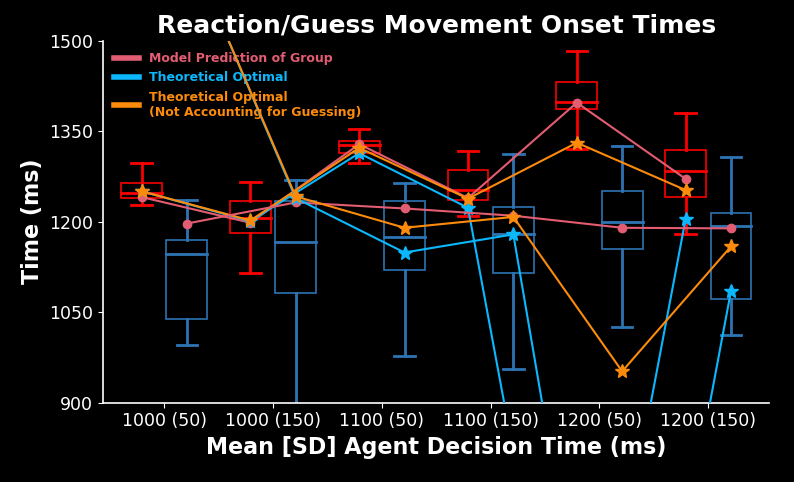

In [26]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time, axis=2)

exp_player_metric1 = get_exp_metric(model_expected.player_behavior.reaction_leave_time, metric_type="fit")
exp_player_metric2 = get_exp_metric(model_expected.player_behavior.gamble_leave_time, metric_type="fit")
true_player_metric1 = get_true_metric(model_true.player_behavior.reaction_leave_time, metric_type="fit")
true_player_metric2 = get_true_metric(model_true.player_behavior.gamble_leave_time, metric_type="fit")

exp_optimal_metric1 = get_exp_metric(model_true.player_behavior.reaction_leave_time,metric_type='optimal')
exp_optimal_metric2 = get_exp_metric(model_true.player_behavior.gamble_leave_time,metric_type='optimal')
true_optimal_metric1 = get_true_metric(model_true.player_behavior.reaction_leave_time,metric_type='optimal')
true_optimal_metric2 = get_true_metric(model_true.player_behavior.gamble_leave_time,metric_type='optimal')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1650, 150)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=None,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=None,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Decision Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


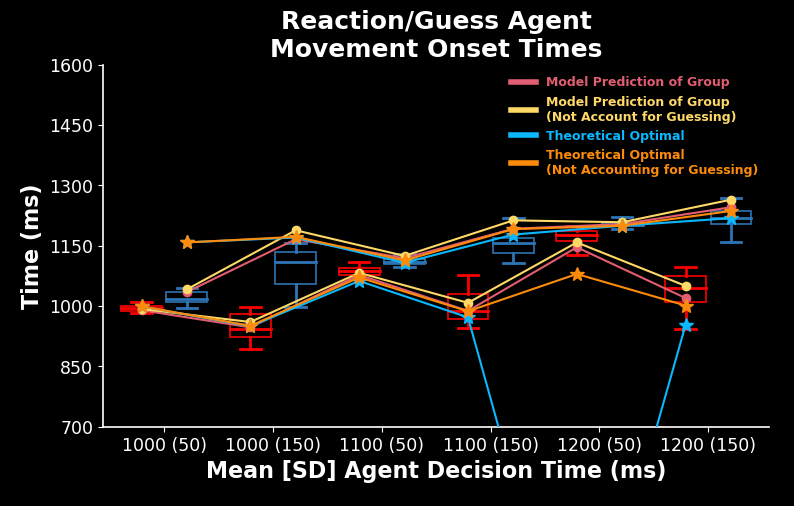

In [27]:
data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.agent_gamble_task_leave_time, axis=2)

exp_player_metric1 = get_exp_metric(model_expected.agent_behavior.reaction_leave_time, metric_type="fit")
exp_player_metric2 = get_exp_metric(model_expected.agent_behavior.gamble_leave_time, metric_type="fit")
true_player_metric1 = get_true_metric(model_true.agent_behavior.reaction_leave_time, metric_type="fit")
true_player_metric2 = get_true_metric(model_true.agent_behavior.gamble_leave_time, metric_type="fit")

exp_optimal_metric1 = get_exp_metric(model_true.agent_behavior.reaction_leave_time,metric_type='optimal')
exp_optimal_metric2 = get_exp_metric(model_true.agent_behavior.gamble_leave_time,metric_type='optimal')
true_optimal_metric1 = get_true_metric(model_true.agent_behavior.reaction_leave_time,metric_type='optimal')
true_optimal_metric2 = get_true_metric(model_true.agent_behavior.gamble_leave_time,metric_type='optimal')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(700, 1750, 150)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Agent\nMovement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/Gamble


In [28]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions
data_metric2 = group.perc_indecisions_that_were_gambles

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_indecision_reaction, model_expected.score_metrics.prob_indecision, metric_type="fit"
)
true_player_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_reaction, model_true.score_metrics.prob_indecision, metric_type="fit"
)

exp_optimal_metric1 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_indecision_reaction, model_true.score_metrics.prob_indecision, metric_type="optimal"
)
true_optimal_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_reaction, model_true.score_metrics.prob_indecision, metric_type="optimal"
)

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_indecision_gamble, model_expected.score_metrics.prob_indecision, metric_type="fit"
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision, metric_type="fit"
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision, metric_type="optimal"
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision, metric_type="optimal"
)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

NameError: name 'reaction_gamble_metric_exp' is not defined

Indecisions That Were Gamble


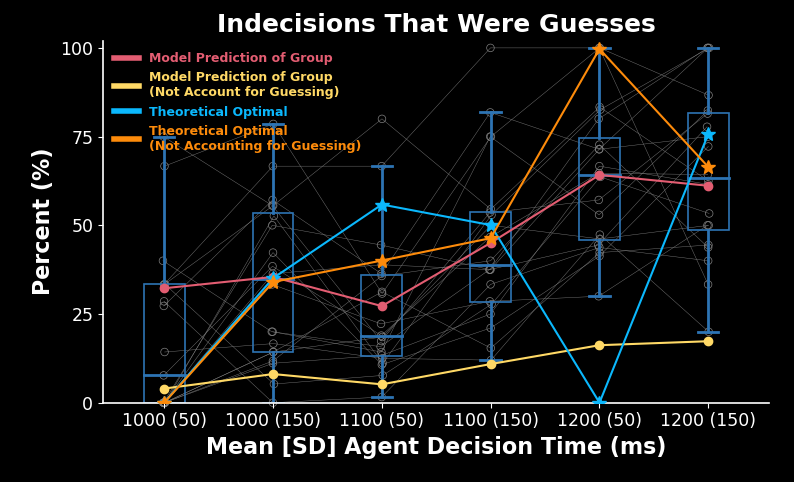

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric2 = group.perc_indecisions_that_were_gambles

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_indecision_gamble, model_expected.score_metrics.prob_indecision, metric_type="fit"
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision, metric_type="fit"
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision,metric_type='optimal'
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble, model_true.score_metrics.prob_indecision,metric_type='optimal'
)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    line_colors=None,
    jitter=True,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Indecisions That Were Guesses")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

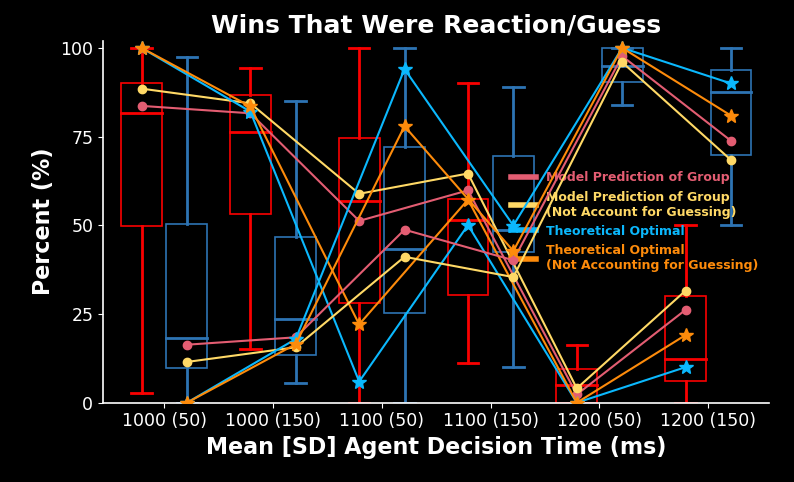

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions
data_metric2 = group.perc_wins_that_were_gambles

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_win_reaction, model_expected.score_metrics.prob_win, metric_type="fit"
)
true_player_metric1 = reaction_gamble_metric_true(model_true.score_metrics.prob_win_reaction, model_true.score_metrics.prob_win, metric_type="fit")

exp_optimal_metric1 = reaction_gamble_metric_exp(model_true.score_metrics.prob_win_reaction, model_true.score_metrics.prob_win, metric_type='optimal')
true_optimal_metric1 = reaction_gamble_metric_true(model_true.score_metrics.prob_win_reaction, model_true.score_metrics.prob_win, metric_type='optimal')

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_win_gamble, model_expected.score_metrics.prob_win, metric_type="fit"
)
true_player_metric2 = reaction_gamble_metric_true(model_true.score_metrics.prob_win_gamble, model_true.score_metrics.prob_win, metric_type="fit")
exp_optimal_metric2 = reaction_gamble_metric_exp(model_true.score_metrics.prob_win_gamble, model_true.score_metrics.prob_win, metric_type='optimal')
true_optimal_metric2 = reaction_gamble_metric_true(model_true.score_metrics.prob_win_gamble, model_true.score_metrics.prob_win, metric_type='optimal')

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


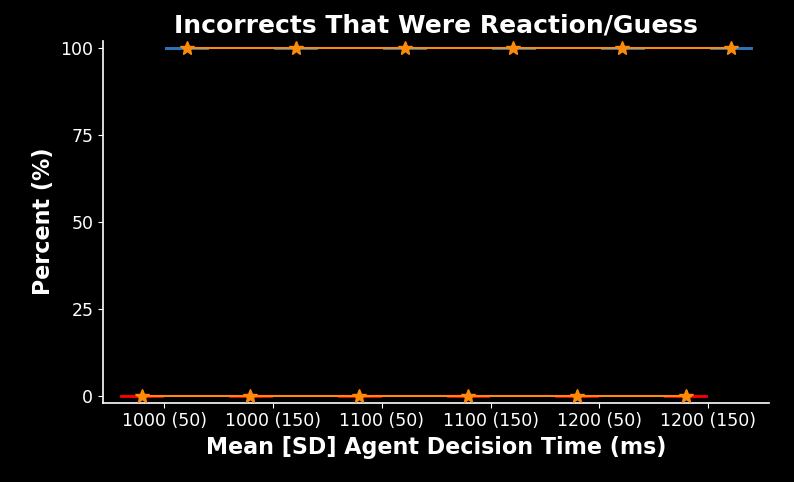

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions
data_metric2 = group.perc_incorrects_that_were_gambles

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_incorrect_reaction, model_expected.score_metrics.prob_incorrect, metric_type="fit"
)
true_player_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_reaction, model_true.score_metrics.prob_incorrect, metric_type="fit"
)

exp_optimal_metric1 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_incorrect_reaction, model_true.score_metrics.prob_incorrect, metric_type='optimal'
)
true_optimal_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_reaction, model_true.score_metrics.prob_incorrect, metric_type='optimal'
)

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_incorrect_gamble, model_expected.score_metrics.prob_incorrect, metric_type="fit"
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_gamble, model_true.score_metrics.prob_incorrect, metric_type="fit"
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_incorrect_gamble, model_true.score_metrics.prob_incorrect, metric_type='optimal'
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_gamble, model_true.score_metrics.prob_incorrect, metric_type='optimal'
)

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=None,
    expected_player=None,
    true_optimal=None,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=None,
    expected_player=None,
    true_optimal=None,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
pf.multiple_models_boxplot(ax, data_metric2, xlocs=xlocs + bw / 1.8, box_width=bw, colors=wheel.seth_blue, jitter=False)
ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs) - 2, max(ylocs) + 2)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win


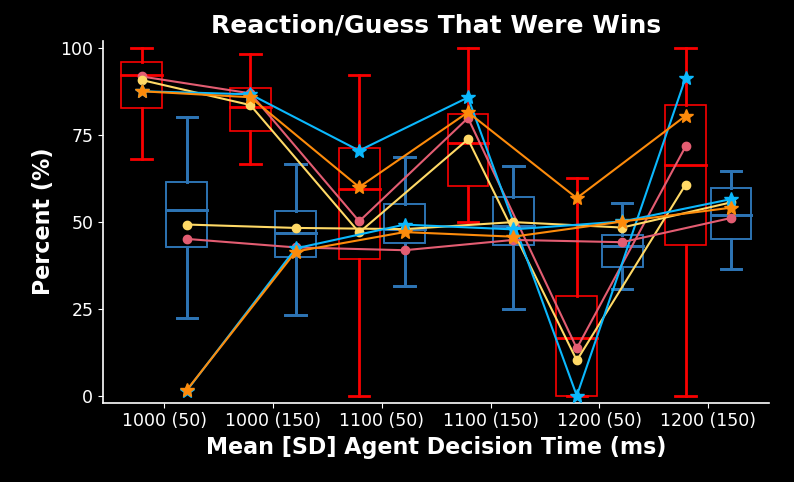

In [ ]:
#
# * Out of x number of reactions/gambles, how many were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_gambles_that_were_wins

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_win_reaction, model_expected.player_behavior.prob_selecting_reaction, metric_type="fit"
)
true_player_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_win_reaction, model_true.player_behavior.prob_selecting_reaction, metric_type="fit"
)

exp_optimal_metric1 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_win_reaction, model_true.player_behavior.prob_selecting_reaction, metric_type="optimal"
)
true_optimal_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_win_reaction, model_true.player_behavior.prob_selecting_reaction, metric_type="optimal"
)

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_win_gamble, model_expected.player_behavior.prob_selecting_gamble, metric_type="fit"
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_win_gamble, model_true.player_behavior.prob_selecting_gamble, metric_type="fit"
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_win_gamble, model_true.player_behavior.prob_selecting_gamble, metric_type="optimal"
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_win_gamble, model_true.player_behavior.prob_selecting_gamble, metric_type="optimal"
)

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
pf.multiple_models_boxplot(ax, data_metric2, xlocs=xlocs + bw / 1.8, box_width=bw, colors=wheel.seth_blue, jitter=False)
ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs) - 2, max(ylocs) + 2)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Indecisions


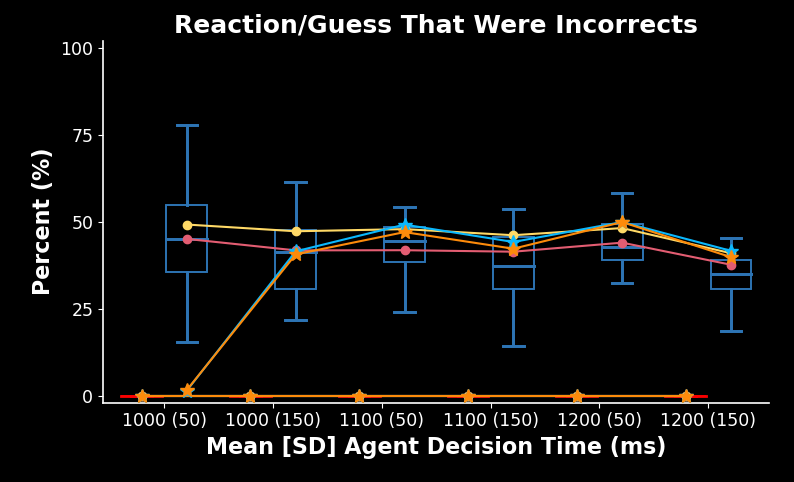

In [ ]:
#
# * Out of x number of reactions/gambles, how many were incorrects
data_metric1 = group.perc_reactions_that_were_incorrects
data_metric2 = group.perc_gambles_that_were_incorrects

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_incorrect_reaction,
    model_expected.player_behavior.prob_selecting_reaction,
    metric_type="fit",
)
true_player_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type="fit",
)

exp_optimal_metric1 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_incorrect_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type='optimal'
)
true_optimal_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type='optimal'
)

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_incorrect_gamble,
    model_expected.player_behavior.prob_selecting_gamble,
    metric_type="fit",
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_gamble,
    model_true.player_behavior.prob_selecting_gamble,
    metric_type="fit",
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_incorrect_gamble,
    model_true.player_behavior.prob_selecting_gamble, 
    metric_type='optimal'
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_incorrect_gamble,
    model_true.player_behavior.prob_selecting_gamble, 
    metric_type='optimal'
)

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
pf.multiple_models_boxplot(
    ax,
    data_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs) - 2, max(ylocs) + 2)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(
        SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model",
        dpi=400,
        transparent=True,
    )
axmain.set_axis_off()

plt.show()

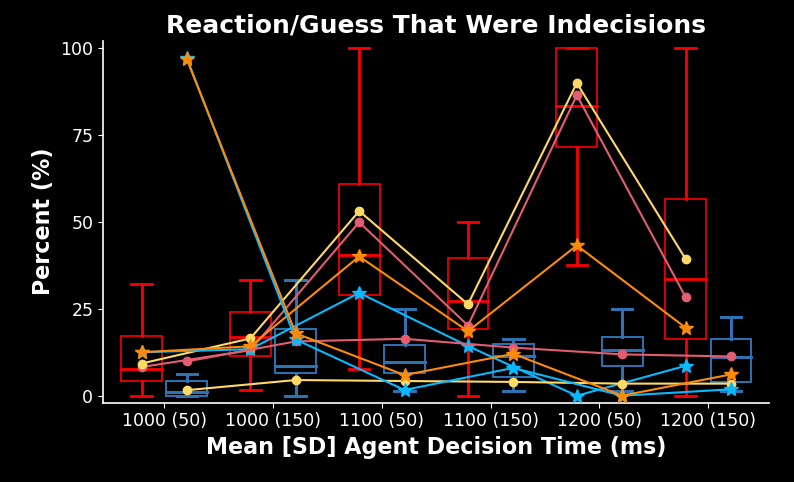

In [ ]:
#
# * Out of x number of reactions/gambles, how many were indecisions
data_metric1 = group.perc_reactions_that_were_indecisions
data_metric2 = group.perc_gambles_that_were_indecisions

exp_player_metric1 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_indecision_reaction,
    model_expected.player_behavior.prob_selecting_reaction,
    metric_type="fit",
)
true_player_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type="fit",
)

exp_optimal_metric1 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_indecision_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type='optimal'
)
true_optimal_metric1 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_reaction,
    model_true.player_behavior.prob_selecting_reaction,
    metric_type='optimal'
)

exp_player_metric2 = reaction_gamble_metric_exp(
    model_expected.score_metrics.prob_indecision_gamble,
    model_expected.player_behavior.prob_selecting_gamble,
    metric_type="fit",
)
true_player_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble,
    model_true.player_behavior.prob_selecting_gamble,
    metric_type="fit",
)
exp_optimal_metric2 = reaction_gamble_metric_exp(
    model_true.score_metrics.prob_indecision_gamble,
    model_true.player_behavior.prob_selecting_gamble,
    metric_type='optimal'
)
true_optimal_metric2 = reaction_gamble_metric_true(
    model_true.score_metrics.prob_indecision_gamble,
    model_true.player_behavior.prob_selecting_gamble,
    metric_type='optimal'
)

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    true_player=true_player_metric1,
    expected_player=exp_player_metric1,
    true_optimal=true_optimal_metric1,
    expected_optimal=exp_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    true_player=true_player_metric2,
    expected_player=exp_player_metric2,
    true_optimal=true_optimal_metric2,
    expected_optimal=exp_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
pf.multiple_models_boxplot(
    ax,
    data_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)
ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw)
ax.set_ylim(min(ylocs) - 2, max(ylocs) + 2)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(
        SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model",
        dpi=400,
        transparent=True,
    )
axmain.set_axis_off()

plt.show()